In [1]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
IMAGE_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold_1/images"
LABEL_ROOT = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold_1/annos"

In [3]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [4]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}


In [5]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [6]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [7]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

In [8]:
pngs = sorted(pngs)
jsons = sorted(jsons)

In [9]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
                
        self.filenames = _filenames
        self.labelnames = _labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        image = cv2.imread(image_path)
        # image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
            
        return image, label, image_path, label_path

In [10]:
train_dataset = XRayDataset(is_train=True, transforms=None)


In [12]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_hamate_val"

In [11]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_pisform_val"

In [11]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_trapezium_val"

In [11]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_trapezoid_val"

In [ ]:
PRED_PATH = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_pisi_val_sec"

In [ ]:
seg_b5_pisform_val

In [ ]:
seg_b5_trapezium_val

In [ ]:
seg_b5_trapezoid_val

In [12]:
image, label, image_path, label_path = train_dataset[0]

In [13]:
image_path.split('/')[-1]

'ID001_image1661130828152_R.png'

In [14]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [15]:
# fold_dir = os.path.join(SAVE_ROOT)
# os.makedirs(fold_dir, exist_ok=True)

# image_dir = os.path.join(fold_dir, 'images')
# os.makedirs(image_dir, exist_ok=True)

# annos_dir = os.path.join(fold_dir, 'annos')
# os.makedirs(annos_dir, exist_ok=True)
filenames = [] 
rles = []

crop_size = (224, 224)  # (height, width)

for i in tqdm(range(len(train_dataset))):
    image, label, image_path, label_path = train_dataset[i]

    # for k in [CLASS2IND['Trapezoid']]: # ,CLASS2IND['Pisiform']
    # for k in [CLASS2IND['Pisiform']]: # ,CLASS2IND['Pisiform']Scaphoid\
    for k in [CLASS2IND['Trapezoid']]: # ,CLASS2IND['Pisiform']Scaphoid

        coords = np.column_stack(np.where(label[:,:,k] > 0))

        x_min, y_min = coords.min(axis=0)  
        x_max, y_max = coords.max(axis=0)  


        if abs(x_max - x_min) > crop_size[0] or abs(y_max - y_min) > crop_size[1]:
            print(abs(x_max - x_min))
            print(abs(y_max - y_min))
            print('????')


        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2

        half_h = crop_size[0] // 2
        half_w = crop_size[1] // 2

        # cropped_image = image[x_min-10:x_max+10,y_min-10:y_max+10]
        # cropped_mask = label[x_min-10:x_max+10,y_min-10:y_max+10,k]

        start_x = max(center_x - half_h, 0)
        start_y = max(center_y - half_w, 0)
        end_x = start_x + crop_size[0]
        end_y = start_y + crop_size[1]

        if end_x > image.shape[0]:
            start_x = image.shape[0] - crop_size[0]
            end_x = image.shape[0]

        if end_y > image.shape[1]:
            start_y = image.shape[1] - crop_size[1]
            end_y = image.shape[1]

        cropped_image = image[start_x:end_x, start_y:end_y]
        cropped_mask = label[start_x:end_x, start_y:end_y, k]

        label_shape = (2048,2048)
        label = np.zeros(label_shape, dtype=np.uint8)
        pred_image_path = os.path.join(PRED_PATH,str(k) + '_' +image_path.split('/')[-1])

        # print(pred_image_path)
        # print(start_x,end_x)
        pred_label = cv2.imread(pred_image_path)[...,0]

        label[start_x:end_x, start_y:end_y] = pred_label

        rle = encode_mask_to_rle(label)
        rles.append(rle)
        filenames.append('_'.join(image_path.split('/')[-1].split('_')[1:]))


    #     output_image_path = os.path.join(image_dir,str(k)+'_'+image_path.split('/')[-1])

    # # break 
    #     cv2.imwrite(output_image_path, cropped_image)

    #     t = str(k)+'_'+label_path.split('/')[-1]
    #     t = t[:-4] + "png"
    #     output_label_path = os.path.join(annos_dir,t)

    #     cv2.imwrite(output_label_path, cropped_mask)
# /data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/mmsegmentation/work_dirs/seg_b5_hamate_val/22_ID001_image1661130828152_R.png

100%|██████████| 160/160 [01:48<00:00,  1.47it/s]


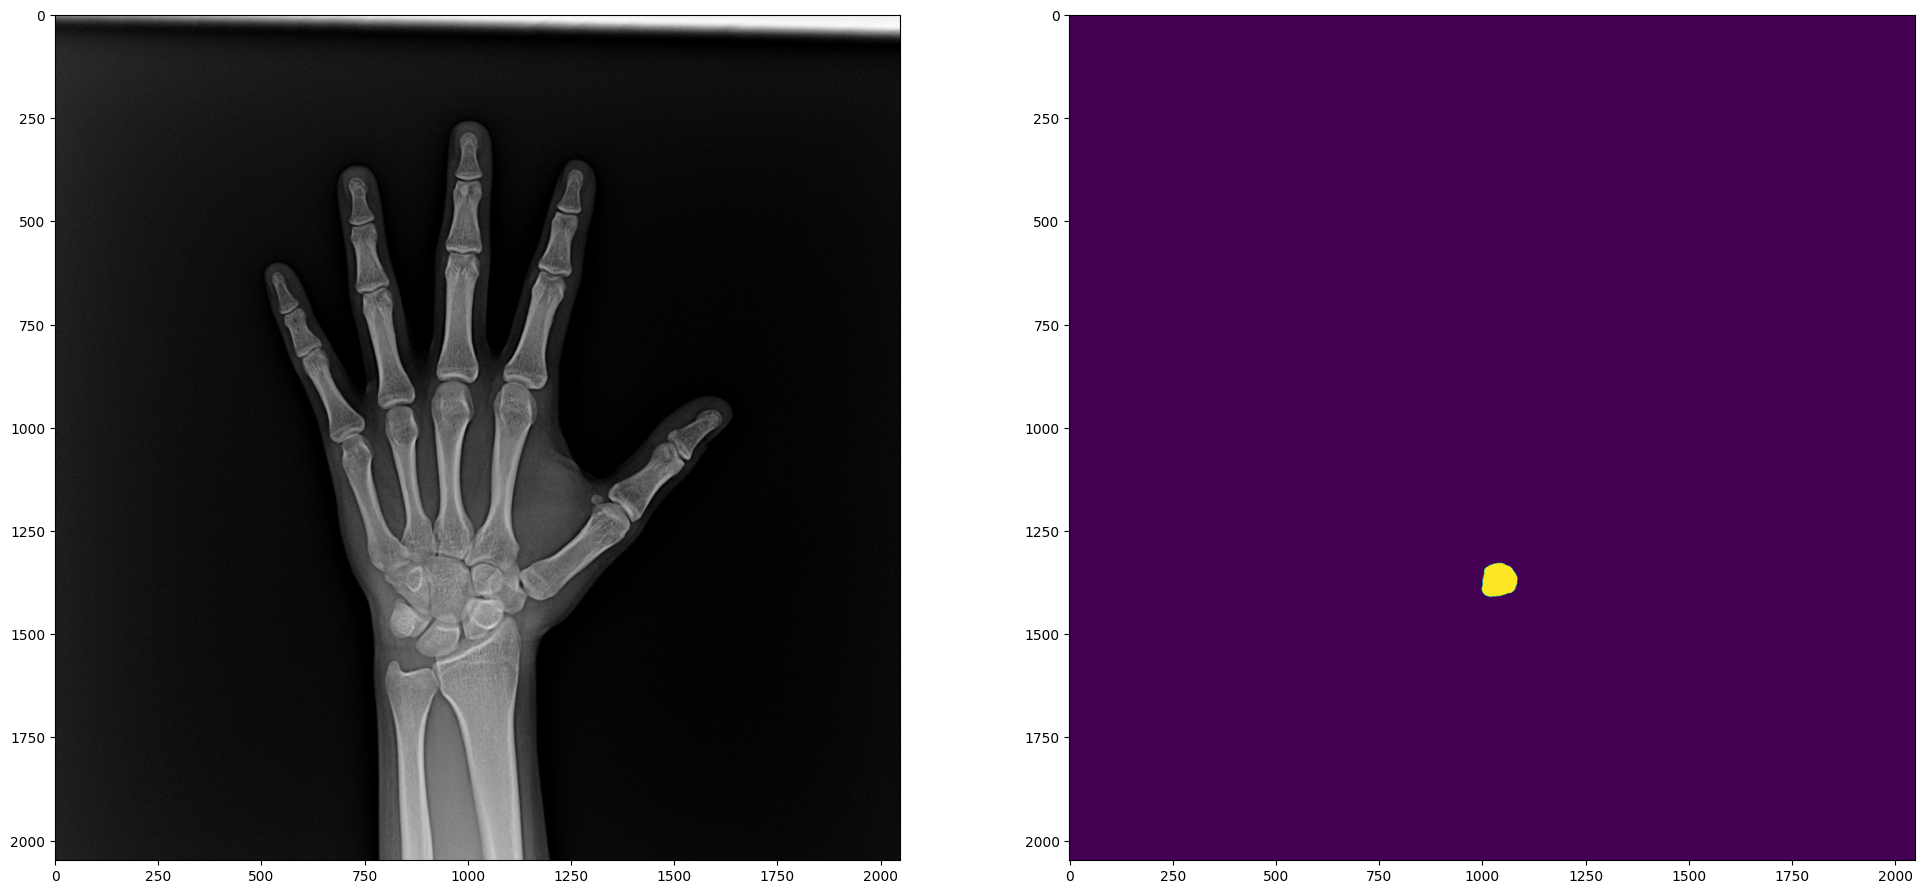

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image) 
ax[1].imshow(label)


In [17]:
df = pd.DataFrame({
    "image_name": filenames,
    "class": ['Trapezoid']*len(filenames),
    "rle": rles,
})

In [18]:
df

,image_name,class,rle
0,image1661130828152_R.png,Trapezoid,2501475 5 2503520 17 2505566 20 2507613 22 250...
1,image1661130891365_L.png,Trapezoid,2708519 2 2710562 17 2712609 21 2714654 26 271...
2,image1661144691792.png,Trapezoid,2923411 7 2925456 14 2927499 24 2929545 30 293...
3,image1661144724044.png,Trapezoid,2874418 6 2876453 27 2878491 40 2880535 46 288...
4,image1661145563354.png,Trapezoid,2800503 5 2802546 18 2804592 22 2806639 25 280...
...,...,...,...
155,image1667265434288.png,Trapezoid,2731045 16 2733090 25 2735134 31 2737177 37 27...
156,image1667266283922.png,Trapezoid,2663348 3 2665389 13 2667427 25 2669472 33 267...
157,image1667266302741.png,Trapezoid,2686099 11 2688143 21 2690183 33 2692227 40 26...
158,image1667350395482.png,Trapezoid,2540465 12 2542509 20 2544553 29 2546600 34 25...


In [19]:
df.to_csv("./output_Trapezoid_crop_val_tta.csv", index=False)

In [20]:
df_input = pd.read_csv('./output_9750.csv')

In [21]:
df_pis = pd.read_csv("./output_Pisiform_crop_val_tta.csv")

In [28]:
df_pis

,image_name,class,rle
0,image1661130828152_R.png,Pisiform,2810941 6 2812984 17 2815030 23 2817076 29 281...
1,image1661130891365_L.png,Pisiform,2923360 11 2925406 15 2927453 18 2929499 22 29...
2,image1661144691792.png,Pisiform,3140688 1 3142731 12 3144778 16 3146824 21 314...
3,image1661144724044.png,Pisiform,3076989 6 3079033 11 3081078 15 3083122 20 308...
4,image1661145563354.png,Pisiform,3103836 5 3105881 11 3107926 16 3109972 21 311...
...,...,...,...
155,image1667265434288.png,Pisiform,2939761 17 2941807 21 2943853 25 2945899 28 29...
156,image1667266283922.png,Pisiform,2870418 4 2872460 20 2874503 29 2876548 35 287...
157,image1667266302741.png,Pisiform,2886589 3 2888626 5 2888632 9 2890672 19 28927...
158,image1667350395482.png,Pisiform,2747527 6 2749570 13 2751615 18 2753661 21 275...


In [22]:
df_ham = pd.read_csv("./output_Hamate_crop_val_tta.csv")

In [27]:
df_ham

,image_name,class,rle
0,image1661130828152_R.png,Hamate,2569231 10 2571271 21 2573314 29 2575360 34 25...
1,image1661130891365_L.png,Hamate,2673483 21 2675529 26 2677576 30 2679622 35 26...
2,image1661144691792.png,Hamate,2909272 7 2911318 12 2913362 20 2915406 28 291...
3,image1661144724044.png,Hamate,2816881 10 2818927 16 2820974 22 2823021 24 28...
4,image1661145563354.png,Hamate,2784299 19 2786345 24 2788390 29 2790435 34 27...
...,...,...,...
155,image1667265434288.png,Hamate,2704268 6 2706313 13 2708356 22 2710401 29 271...
156,image1667266283922.png,Hamate,2634839 7 2636885 14 2638931 22 2640978 26 264...
157,image1667266302741.png,Hamate,2638820 5 2640867 8 2642914 11 2644962 12 2647...
158,image1667350395482.png,Hamate,2499689 12 2501728 26 2503773 36 2505819 49 25...


In [23]:
df_trapezium = pd.read_csv("./output_Trapezium_crop_val_tta.csv")

In [26]:
df_trapezium

,image_name,class,rle
0,image1661130828152_R.png,Trapezium,2503493 12 2505538 20 2507584 25 2509631 28 25...
1,image1661130891365_L.png,Trapezium,2694218 9 2696263 17 2698309 20 2700355 24 270...
2,image1661144691792.png,Trapezium,2902879 8 2904924 17 2906971 20 2909018 23 291...
3,image1661144724044.png,Trapezium,2851945 5 2853989 14 2856035 17 2858081 21 286...
4,image1661145563354.png,Trapezium,2757457 15 2759502 20 2761547 25 2763592 30 27...
...,...,...,...
155,image1667265434288.png,Trapezium,2720853 11 2722897 17 2724943 21 2726989 25 27...
156,image1667266283922.png,Trapezium,2677617 8 2679661 18 2681708 21 2683754 24 268...
157,image1667266302741.png,Trapezium,2698440 8 2700486 13 2702530 20 2704575 25 270...
158,image1667350395482.png,Trapezium,2534283 5 2536326 16 2538370 22 2540416 25 254...


In [24]:
df_trapezoid = pd.read_csv("./output_Trapezoid_crop_val_tta.csv")

In [25]:
df_trapezoid

,image_name,class,rle
0,image1661130828152_R.png,Trapezoid,2501475 5 2503520 17 2505566 20 2507613 22 250...
1,image1661130891365_L.png,Trapezoid,2708519 2 2710562 17 2712609 21 2714654 26 271...
2,image1661144691792.png,Trapezoid,2923411 7 2925456 14 2927499 24 2929545 30 293...
3,image1661144724044.png,Trapezoid,2874418 6 2876453 27 2878491 40 2880535 46 288...
4,image1661145563354.png,Trapezoid,2800503 5 2802546 18 2804592 22 2806639 25 280...
...,...,...,...
155,image1667265434288.png,Trapezoid,2731045 16 2733090 25 2735134 31 2737177 37 27...
156,image1667266283922.png,Trapezoid,2663348 3 2665389 13 2667427 25 2669472 33 267...
157,image1667266302741.png,Trapezoid,2686099 11 2688143 21 2690183 33 2692227 40 26...
158,image1667350395482.png,Trapezoid,2540465 12 2542509 20 2544553 29 2546600 34 25...


In [31]:
df_val_all = pd.concat([df_pis,df_ham,df_trapezium,df_trapezoid])

In [34]:
df_val_all.to_csv('./crop_val_pis_ham_trapezium_trapezoid.csv',index=False)